# Clean training dataset

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches

## Read the training dataset

In [2]:
# load data for training
DataTrain = np.load("data/train/datasetMC_train.npz")  # load dataset

Dt = DataTrain["data"]            # data: magnetic configurations
Vt = DataTrain["values"]          # values: Dzyaloshinkii-Moriya constant and applied magnetic field
Lt = DataTrain["labels"]          # labels: FM, SK, SP
Pt = DataTrain["properties"]      # properties: total magnetization and topological charge

In [3]:
# check shapes
print("Training dataset shape: {}".format(Dt.shape))
print("Values shape: {}".format(Vt.shape))
print("Labels shape: {}".format(Lt.shape))
print("Properties shape: {}".format(Pt.shape))

Training dataset shape: (700, 200, 200)
Values shape: (700, 2)
Labels shape: (700,)
Properties shape: (700, 2)


## Clean training dataset

In [4]:
DataFM, PropFM = Dt[Lt == "FM"], Pt[Lt == "FM"]
DataSK, PropSK = Dt[Lt == "SK"], Pt[Lt == "SK"]
DataSP, PropSP = Dt[Lt == "SP"], Pt[Lt == "SP"]

print(DataFM.shape, DataSK.shape, DataSP.shape)
print(PropFM.shape, PropSK.shape, PropSP.shape)

(200, 200, 200) (300, 200, 200) (200, 200, 200)
(200, 2) (300, 2) (200, 2)


In [5]:
cond_FM = PropFM[:,0] > .95
cond_SK = PropSK[:,0] > .399
cond_SP = PropSP[:,1] > -.9

V_FM, P_FM = Vt[Lt == "FM"], Pt[Lt == "FM"]
V_SK, P_SK = Vt[Lt == "SK"], Pt[Lt == "SK"]
V_SP, P_SP = Vt[Lt == "SP"], Pt[Lt == "SP"]

print(V_FM.shape, V_SK.shape, V_SP.shape)
print(P_FM.shape, P_SK.shape, P_SP.shape)

V = np.vstack((V_FM[cond_FM], V_SK[cond_SK], V_SP[cond_SP]))
P = np.vstack((P_FM[cond_FM], P_SK[cond_SK], P_SP[cond_SP]))

print(V.shape)
print(P.shape)

(200, 2) (300, 2) (200, 2)
(200, 2) (300, 2) (200, 2)
(470, 2)
(470, 2)


In [6]:
DataFM = DataFM[cond_FM]
DataSK = DataSK[cond_SK]
DataSP = DataSP[cond_SP]

PropFM = PropFM[cond_FM]
PropSK = PropSK[cond_SK]
PropSP = PropSP[cond_SP]

print(DataFM.shape, DataSK.shape, DataSP.shape)
print(PropFM.shape, PropSK.shape, PropSP.shape)

(200, 200, 200) (106, 200, 200) (164, 200, 200)
(200, 2) (106, 2) (164, 2)


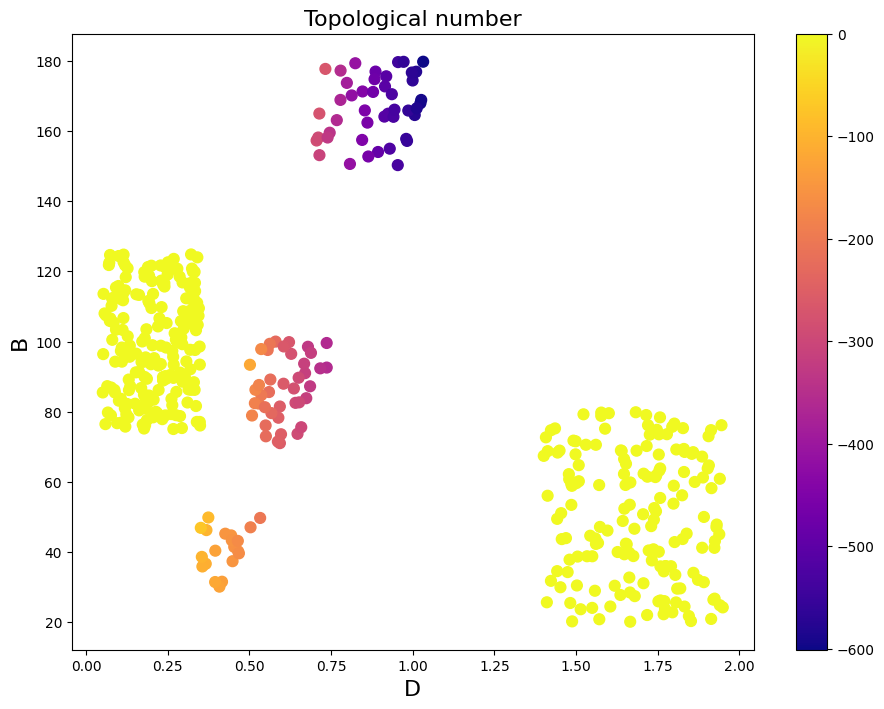

In [7]:


fig, ax = plt.subplots(figsize=(11,8))

m = ax.scatter(*V.T, c=(P.T)[1], cmap="plasma", marker="o", s=60)

ax.set_title("Topological number", size=16)
ax.set_xlabel("D", size=16)
ax.set_ylabel("B", size=16)


cbar = fig.colorbar(m)

plt.show()

In [8]:
def rot_fm_state(X):
    """Random coherent rotation of FM configurations."""
    
    Sz   = np.cos(X * np.pi)
    Rand = np.cos(2. * np.pi * np.random.rand(len(X)))
    
    SzNew = np.transpose(Rand * Sz.T)
    
    return np.arccos(SzNew) / np.pi

In [9]:
DataFM = rot_fm_state(DataFM)

***

In [10]:
DataSK.shape, DataSP.shape, DataFM.shape

((106, 200, 200), (164, 200, 200), (200, 200, 200))

In [12]:
train_ratio = 0.8
dev_ratio = 0.1
test_ratio = 0.1
random_seed = 42

fe_size = DataFM.shape[0]
sk_size = DataSK.shape[0]
sp_size = DataSP.shape[0]

# fe_labels = np.full(fe_size, 'ferromagnet')
# sk_labels = np.full(sk_size, 'skyrmion')
# sp_labels = np.full(sp_size, 'spiral')

fe_labels = np.full(fe_size, 0)
sk_labels = np.full(sk_size, 1)
sp_labels = np.full(sp_size, 2)

np.random.seed(random_seed)

rnd_fe_idcs = np.random.permutation(fe_size)
rnd_sk_idcs = np.random.permutation(sk_size)
rnd_sp_idcs = np.random.permutation(sp_size)

DataFM, fe_labels = DataFM[rnd_fe_idcs], fe_labels[rnd_fe_idcs]
DataSK, sk_labels = DataSK[rnd_sk_idcs], sk_labels[rnd_sk_idcs]
DataSP, sp_labels = DataSP[rnd_sp_idcs], fe_labels[rnd_sp_idcs]

train_fe_stop = int(fe_size * train_ratio)
dev_fe_stop = int(fe_size * dev_ratio) + train_fe_stop
train_fe_data, train_fe_labels = DataFM[:train_fe_stop], fe_labels[:train_fe_stop]
dev_fe_data, dev_fe_labels = DataFM[train_fe_stop:dev_fe_stop], fe_labels[train_fe_stop:dev_fe_stop]
test_fe_data, test_fe_labels = DataFM[dev_fe_stop:], fe_labels[dev_fe_stop:]

train_sk_stop = int(sk_size * train_ratio)
dev_sk_stop = int(sk_size * dev_ratio) + train_sk_stop
train_sk_data, train_sk_labels = DataSK[:train_sk_stop], sk_labels[:train_sk_stop]
dev_sk_data, dev_sk_labels = DataSK[train_sk_stop:dev_sk_stop], sk_labels[train_sk_stop:dev_sk_stop]
test_sk_data, test_sk_labels = DataSK[dev_sk_stop:], sk_labels[dev_sk_stop:]

train_sp_stop = int(sp_size * train_ratio)
dev_sp_stop = int(sp_size * dev_ratio) + train_sp_stop
train_sp_data, train_sp_labels = DataSP[:train_sp_stop], sp_labels[:train_sp_stop]
dev_sp_data, dev_sp_labels = DataSP[train_sp_stop:dev_sp_stop], sp_labels[train_sp_stop:dev_sp_stop]
test_sp_data, test_sp_labels = DataSP[dev_sp_stop:], sp_labels[dev_sp_stop:]


train_images = np.vstack([train_fe_data, train_sk_data, train_sp_data])
dev_images = np.vstack([dev_fe_data, dev_sk_data, dev_sp_data])
test_images = np.vstack([test_fe_data, test_sk_data, test_sp_data])

train_labels = np.hstack([train_fe_labels, train_sk_labels, train_sp_labels])
dev_labels = np.hstack([dev_fe_labels, dev_sk_labels, dev_sp_labels])
test_labels = np.hstack([test_fe_labels, test_sk_labels, test_sp_labels])

train_shuffle_indeces = np.random.permutation(len(train_images))
dev_shuffle_indeces = np.random.permutation(len(dev_images))
test_shuffle_indeces = np.random.permutation(len(test_images))

train_images = train_images[train_shuffle_indeces]
dev_images = dev_images[dev_shuffle_indeces]
test_images = test_images[test_shuffle_indeces]

train_labels = train_labels[train_shuffle_indeces]
dev_labels = dev_labels[dev_shuffle_indeces]
test_labels = test_labels[test_shuffle_indeces]

print(train_images.shape, dev_images.shape, test_images.shape)
print(train_labels.shape, dev_labels.shape, test_labels.shape)

train_images = train_images * 255
dev_images = dev_images * 255
test_images = test_images * 255

train_images = [image.reshape((200, 200, 1)) for image in train_images]
dev_images = [image.reshape((200, 200, 1)) for image in dev_images]
test_images = [image.reshape((200, 200, 1)) for image in test_images]

np.savez('data/train/skyrmion_dataset',
         train_images=train_images, train_labels=train_labels,
         dev_images=dev_images, dev_labels=dev_labels,
         test_images=test_images, test_labels=test_labels)

(375, 200, 200) (46, 200, 200) (49, 200, 200)
(375,) (46,) (49,)
